https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

(1797, 64)


<Figure size 432x288 with 0 Axes>

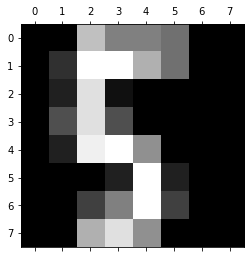

In [15]:
dig = load_digits()
plt.gray()
plt.matshow(dig.images[25])

onehot_target = pd.get_dummies(dig.target)



x_train, x_val, y_train, y_val = train_test_split(dig.data, onehot_target, test_size=0.1, random_state=20)
# shape of x_train :(1617, 64)
# shape of y_train :(1617, 10)
print(dig.data.shape)

Input layer - 64 neurons (input image array)
Hidden layer 1 - 128 neurons (arbitrary)
Hidden layer 2 - 128 neurons (arbitrary)
Output layer - 10 neurons (output one-hot array)

In [18]:
#with libraries
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=64)

scores = model.evaluate(x_val, y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 26,122
Trainable params: 26,122
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1617/1617 [==============================] - 0s 153us/step - loss: 2.0566 - categorical_accuracy: 0.4712
Epoch 2/50
1617/1617 [==============================] - 0s 27us/step - loss: 1.3693 - categorical_accuracy: 0.8411
Epoch 3/50
1617/1617 [==============================] - 0s 24us/step - loss: 0.8917 - categorical_accuracy: 0.9017
Epoch 4/50
1617/1617 [============

WITHOUT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

dig = load_digits()
onehot_target = pd.get_dummies(dig.target)
x_train, x_val, y_train, y_val = train_test_split(dig.data, onehot_target, test_size=0.1, random_state=20)

def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

class MyNN:
    def __init__(self, x, y):
        self.x = x
        neurons = 128
        self.lr = 0.5
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))
        self.y = y

    def feedforward(self):
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)
        
    def backprop(self):
        loss = error(self.a3, self.y)
        print('Error :', loss)
        a3_delta = cross_entropy(self.a3, self.y) # w3
        z2_delta = np.dot(a3_delta, self.w3.T)
        a2_delta = z2_delta * sigmoid_derv(self.a2) # w2
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1) # w1

        self.w3 -= self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 -= self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0)
        self.w1 -= self.lr * np.dot(self.x.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return self.a3.argmax()
			
model = MyNN(x_train/16.0, np.array(y_train))

epochs = 1500
for x in range(epochs):
    model.feedforward()
    model.backprop()
		
def get_acc(x, y):
    acc = 0
    for xx,yy in zip(x, y):
        s = model.predict(xx)
        if s == np.argmax(yy):
            acc +=1
    return acc/len(x)*100
	
print("Training accuracy : ", get_acc(x_train/16, np.array(y_train)))
print("Test accuracy : ", get_acc(x_val/16, np.array(y_val)))